<a href="https://colab.research.google.com/github/isaacchunn/SC1015_MiniPrj_Airbnb/blob/main/Airbnb_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dataset : Airbnb Singapore Dataset from InsideAirbnb
#### Question : If we were an AirBnb host, how can we maximise our profit?


Dataset from Airbnb : **"Singapore, 29 December 2022"**  
Source: http://insideairbnb.com/get-the-data/


# Contents
  1. KMeans
  2. Random Forest

---

### Essential Libraries

Import essential libraries such as numpy, pandas, matplotlib and seaborn.

> NumPy : Library for Numeric Computations in Python  
> Pandas : Library for Data Acquisition and Preparation  
> Matplotlib : Low-level library for Data Visualization  
> Seaborn : Higher-level library for Data Visualization  

In [394]:
# Isaac Chun Jun Heng U2221389B
# J'sen Ong Jia Xuan  U2220457J
# Tang Teck Meng U2221809C

In [395]:
#Basic libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt #We only need pyplot
sb.set() #Set the default Seaborn style for graphics

### Additional Libraries

Import additional libraries

> sklearn : Conduct linear regression analysis

In [396]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

### General Utility Functions

In [397]:
def countOutliers (df):
    #Get the q1 and q3 datas to find out the 25% and 75% range, then calculate inter quartile range and then find out whiskers.
    #Then count how many points lie outside of this range.
    q1 = df.quantile(0.25)
    q3 = df.quantile(0.75)
    #Interquartile
    iqr = q3 - q1
    #Calculate whiskers
    leftWhisker = q1 - (1.5 * iqr)
    rightWhisker = q3 + (1.5 * iqr)
    outliers = 0;
    #Loop through data now
    for data in df:
        if(data < leftWhisker or data > rightWhisker):
            outliers+=1

    return outliers

In [398]:
def removeOutliers(df, colName):
  q1 = df[colName].quantile(0.25)
  q3 = df[colName].quantile(0.75)
  iqr = q3-q1
  low = q1 - 1.5 * iqr
  high = q3 + 1.5 * iqr
  result = df.loc[(df[colName] >= low) & (df[colName] <= high)]
  return result

In [399]:
def remove_outliers(df, columns, factor=1.5):
    # loop through each column and remove outliers based on the IQR method
    for col in columns:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        upper_bound = q3 + factor * iqr
        lower_bound = q1 - factor * iqr
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    
    return df

### Mount Google Drive (unused, uncomment if need add anything from google drive.)

In [400]:
# from google.colab import drive 
# drive.mount('/content/gdrive')

---

>## Hypothesis  

1. The number of amenities a listing provides will affect its price, the more the amenities, the higher the listing price
2. Variables related to a listing's review will have positive correlation to listing's price

---

>## Import the Dataset  

We have imported the cleaned dataset based on our EDA done in the other files.

In [401]:
url = "https://raw.githubusercontent.com/isaacchunn/SC1015_MiniPrj_Airbnb/main/listings_cleaned.csv"
airDF = pd.read_csv(url)
airDF.head()

,name,listing_url,description,neighborhood_overview,host_response_time,host_response_rate,host_acceptance_rate,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,...,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable
0,Ensuite Room (Room 1 & 2) near EXPO,https://www.airbnb.com/rooms/71609,For 3 rooms.Book room 1&2 and room 4<br /><br ...,NaN,within a few hours,90%,100%,Tampines,East Region,1.34537,...,20.0,4.44,4.37,4.00,4.63,4.78,4.26,4.32,NaN,f
1,B&B Room 1 near Airport & EXPO,https://www.airbnb.com/rooms/71896,<b>The space</b><br />Vocational Stay Deluxe B...,NaN,within a few hours,90%,100%,Tampines,East Region,1.34754,...,24.0,4.16,4.22,4.09,4.43,4.43,4.17,4.04,NaN,t
2,Room 2-near Airport & EXPO,https://www.airbnb.com/rooms/71903,"Like your own home, 24hrs access.<br /><br /><...",Quiet and view of the playground with exercise...,within a few hours,90%,100%,Tampines,East Region,1.34531,...,47.0,4.41,4.39,4.52,4.63,4.64,4.50,4.36,NaN,f
3,Amazing Room with window 10min to Redhill,https://www.airbnb.com/rooms/275343,Awesome location and host <br />Room near INSE...,NaN,within an hour,100%,85%,Bukit Merah,Central Region,1.29015,...,22.0,4.40,4.16,4.26,4.47,4.42,4.53,4.63,S0399,f
4,15 mins to Outram MRT Single Room,https://www.airbnb.com/rooms/275344,Lovely home for the special guest !<br /><br /...,Bus stop <br />Food center <br />Supermarket,within an hour,100%,85%,Bukit Merah,Central Region,1.28836,...,14.0,4.50,4.69,4.23,4.62,4.54,4.62,4.46,S0399,f


In [402]:
airDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3035 entries, 0 to 3034
Data columns (total 27 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   name                          3035 non-null   object 
 1   listing_url                   3035 non-null   object 
 2   description                   2968 non-null   object 
 3   neighborhood_overview         1968 non-null   object 
 4   host_response_time            2405 non-null   object 
 5   host_response_rate            2405 non-null   object 
 6   host_acceptance_rate          2284 non-null   object 
 7   neighbourhood_cleansed        3018 non-null   object 
 8   neighbourhood_group_cleansed  3018 non-null   object 
 9   latitude                      3018 non-null   float64
 10  longitude                     3018 non-null   float64
 11  property_type                 3018 non-null   object 
 12  accommodates                  3018 non-null   float64
 13  ame

In [403]:
print(airDF.dtypes)

name                             object
listing_url                      object
description                      object
neighborhood_overview            object
host_response_time               object
host_response_rate               object
host_acceptance_rate             object
neighbourhood_cleansed           object
neighbourhood_group_cleansed     object
latitude                        float64
longitude                       float64
property_type                    object
accommodates                    float64
amenities                        object
price                            object
minimum_nights                  float64
maximum_nights                  float64
number_of_reviews               float64
review_scores_rating            float64
review_scores_accuracy          float64
review_scores_cleanliness       float64
review_scores_checkin           float64
review_scores_communication     float64
review_scores_location          float64
review_scores_value             float64


---

>## Cleaning our DataFrame/Dataset

### 1. Drop properties with N/A or 0% acceptance rate as these properties do not get stayed at by visitors.

In [404]:
#Drop all the properties that has no host acceptance rate then drop
airDF = airDF.dropna(subset=["host_acceptance_rate"])
#Then remove all the 0% acceptance rate
airDF = airDF[airDF["host_acceptance_rate"] != 0]
#Resort our indexes
airDF = airDF.reset_index(drop=True)
airDF.head(n=5)

,name,listing_url,description,neighborhood_overview,host_response_time,host_response_rate,host_acceptance_rate,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,...,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable
0,Ensuite Room (Room 1 & 2) near EXPO,https://www.airbnb.com/rooms/71609,For 3 rooms.Book room 1&2 and room 4<br /><br ...,NaN,within a few hours,90%,100%,Tampines,East Region,1.34537,...,20.0,4.44,4.37,4.00,4.63,4.78,4.26,4.32,NaN,f
1,B&B Room 1 near Airport & EXPO,https://www.airbnb.com/rooms/71896,<b>The space</b><br />Vocational Stay Deluxe B...,NaN,within a few hours,90%,100%,Tampines,East Region,1.34754,...,24.0,4.16,4.22,4.09,4.43,4.43,4.17,4.04,NaN,t
2,Room 2-near Airport & EXPO,https://www.airbnb.com/rooms/71903,"Like your own home, 24hrs access.<br /><br /><...",Quiet and view of the playground with exercise...,within a few hours,90%,100%,Tampines,East Region,1.34531,...,47.0,4.41,4.39,4.52,4.63,4.64,4.50,4.36,NaN,f
3,Amazing Room with window 10min to Redhill,https://www.airbnb.com/rooms/275343,Awesome location and host <br />Room near INSE...,NaN,within an hour,100%,85%,Bukit Merah,Central Region,1.29015,...,22.0,4.40,4.16,4.26,4.47,4.42,4.53,4.63,S0399,f
4,15 mins to Outram MRT Single Room,https://www.airbnb.com/rooms/275344,Lovely home for the special guest !<br /><br /...,Bus stop <br />Food center <br />Supermarket,within an hour,100%,85%,Bukit Merah,Central Region,1.28836,...,14.0,4.50,4.69,4.23,4.62,4.54,4.62,4.46,S0399,f


### 2. Clean the price column using code as it has "$", "," and "." 


In [405]:
airDF["price"]

0       $46,437.00 
1           $81.00 
2           $81.00 
3           $52.00 
4           $49.00 
           ...     
2279        $45.00 
2280        $45.00 
2281       $186.00 
2282       $797.00 
2283       $434.00 
Name: price, Length: 2284, dtype: object

In [406]:
breaks = [",", "$"]
for i in range(len(airDF["price"])):
    s = airDF.loc[:,("price")][i]
    for x in breaks:
        s = s.replace(x,"")
    s = "".join(s.split(".")[:-1])
    airDF.loc[:,("price")][i] = int(s)
airDF = airDF.astype({'price': 'int32'})

<ipython-input-406-e0f04e7ead66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  airDF.loc[:,("price")][i] = int(s)


We also remove any outliers as it is unrealistic for a property to have above > $45,000 per night

In [407]:
airDF = remove_outliers(airDF, ["price"])
airDF = airDF[airDF.price < 350]
#Resort our indexes
airDF = airDF.reset_index(drop=True)
airDF["price"]

0        81
1        81
2        52
3        49
4       175
       ... 
1746     45
1747     45
1748     45
1749     45
1750    186
Name: price, Length: 1751, dtype: int32

### 3. Convert the amenities column to a list, and add a new column with the number of amenities to be used for our prediction.

In [408]:
airDF["amenities"]

0       ["Cooking basics", "Refrigerator", "Kitchen", ...
1       ["Cooking basics", "Heating", "Kitchen", "Hair...
2       ["Air conditioning", "Shampoo", "Smoke alarm",...
3       ["Air conditioning", "Shampoo", "Smoke alarm",...
4       ["Cooking basics", "Kitchen", "Private entranc...
                              ...                        
1746    ["Air conditioning", "Fire extinguisher", "Sec...
1747    ["Air conditioning", "Fire extinguisher", "Sec...
1748    ["Air conditioning", "Fire extinguisher", "Sec...
1749    ["Air conditioning", "Fire extinguisher", "Sec...
1750    ["Air conditioning", "Fire extinguisher", "Sec...
Name: amenities, Length: 1751, dtype: object

In [409]:
#Add a new column of amenities
airDF["no_amenities"] = 0
#Replace all with the integer variant
count = 0
for x in airDF["amenities"]:   
    #Convert string into list
    #Convert string into list
    x = x.replace('[',"")
    x = x.replace(']',"")
    x = x.replace('"', "")
    x = x.replace(", ", ",")
    x = x.split(",")
    airDF["amenities"][count] = x
    airDF["no_amenities"][count] = len(x)
    count += 1

<ipython-input-409-a56617251945>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  airDF["amenities"][count] = x
<ipython-input-409-a56617251945>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  airDF["no_amenities"][count] = len(x)


In [410]:
airDF["amenities"].head(n=5)

0    [Cooking basics, Refrigerator, Kitchen, Hair d...
1    [Cooking basics, Heating, Kitchen, Hair dryer,...
2    [Air conditioning, Shampoo, Smoke alarm, Long ...
3    [Air conditioning, Shampoo, Smoke alarm, Long ...
4    [Cooking basics, Kitchen, Private entrance, Ha...
Name: amenities, dtype: object

In [411]:
airDF["no_amenities"].head(n=5)

0    31
1    26
2    17
3    18
4    32
Name: no_amenities, dtype: int64

In [412]:
#Want to visualize the total count of amenities so we can form a generalization such that our number of amenities remains reliable.
amenityCount = {}
for x in airDF["amenities"]:
    for item in x:
        if item in amenityCount:
            amenityCount[item] += 1
        else:
            amenityCount[item] = 1
        
#Add it to a DF
amenityCountDF = pd.DataFrame(columns = ["amenity", "count"])
count = 0
for keys, values in amenityCount.items():
    amenityCountDF.loc[count] = [keys, values]
    count += 1

#Sort the DF
amenityCountDF = amenityCountDF.sort_values(by="count", ascending = False)
amenityCountDF.head(n=15)

,amenity,count
9,Long term stays allowed,1746
7,Wifi,1702
32,Air conditioning,1611
17,Essentials,1503
2,Kitchen,1426
43,Hangers,1387
30,Washer,1356
39,Iron,1325
26,Hot water,1233
3,Hair dryer,1153


In [413]:
amenityCountDF.tail(n=10)

,amenity,count
259,Backyard - Not fully fenced,1
257,HDTV with standard cable,1
179,Stainless steel electric stove,1
255,Paid parking garage on premises \u2013 20 spaces,1
253,Private outdoor pool - olympic-sized,1
183,Wifi \u2013 22 Mbps,1
250,BBQ grill: electric,1
249,Coffee maker: drip coffee maker,1
184,Hitachi refrigerator,1
335,Fireplace guards,1


We have decided to only use those amenities that are very prominent in most of the listings as the number of amenities should be consistent, and not be filled with many values that do not matter. For example, we do not know what Fire TV is.

In [414]:
#Changeable cutoff that are determined by us to check for robustness of our model
amenityCutOff = 30

In [415]:
uselessAmenityList = amenityCountDF[amenityCountDF["count"] <= amenityCutOff]["amenity"].values.tolist()

In [416]:
#Remove all values in our df that correspond to our useless amenity list
count = 0
for x in airDF["amenities"]:
    l = [i for i in x if i not in uselessAmenityList]
    airDF["amenities"][count] = l
    airDF["no_amenities"][count] = len(l)
    count +=1

<ipython-input-416-ae78827c68ad>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  airDF["amenities"][count] = l
<ipython-input-416-ae78827c68ad>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  airDF["no_amenities"][count] = len(l)


### 4. Fill in na values in host_response_time to be a value as we are using it to gather insights

In [417]:
print("Null values:", airDF["host_response_time"].isnull().sum().sum())

Null values: 87


In [418]:
airDF["host_response_time"].value_counts()

within an hour        642
within a few hours    577
within a day          355
a few days or more     90
Name: host_response_time, dtype: int64

In [419]:
#Fill it to be the worst scenario to achieve better distribution
airDF = airDF.fillna(value = {"host_response_time": "a few days or more"})
None

In [420]:
print("Null values:", airDF["host_response_time"].isnull().sum().sum())

Null values: 0


In [421]:
airDF["host_response_time"].value_counts()

within an hour        642
within a few hours    577
within a day          355
a few days or more    177
Name: host_response_time, dtype: int64

---

>## Splitting the Dataset

In [422]:
#Split the dataset into train and test in 80:20 ratio
train_data, test_data = train_test_split(airDF, test_size = 0.2, random_state = 55)

#Print out what we have in our test and train data
print("Train Data :")
print("Data type : ", type(train_data))
print("Data dim : ", train_data.shape)
print("---------------------------------------")
print("Test Data :")
print("Data type : ", type(test_data))
print("Data dim : ", test_data.shape)
print("---------------------------------------")

Train Data :
Data type :  <class 'pandas.core.frame.DataFrame'>
Data dim :  (1400, 28)
---------------------------------------
Test Data :
Data type :  <class 'pandas.core.frame.DataFrame'>
Data dim :  (351, 28)
---------------------------------------


---

>## 1. Multi-variate K Means

In [423]:
priceDF = airDF["price"]
priceDF.head(n=5)

0     81
1     81
2     52
3     49
4    175
Name: price, dtype: int32

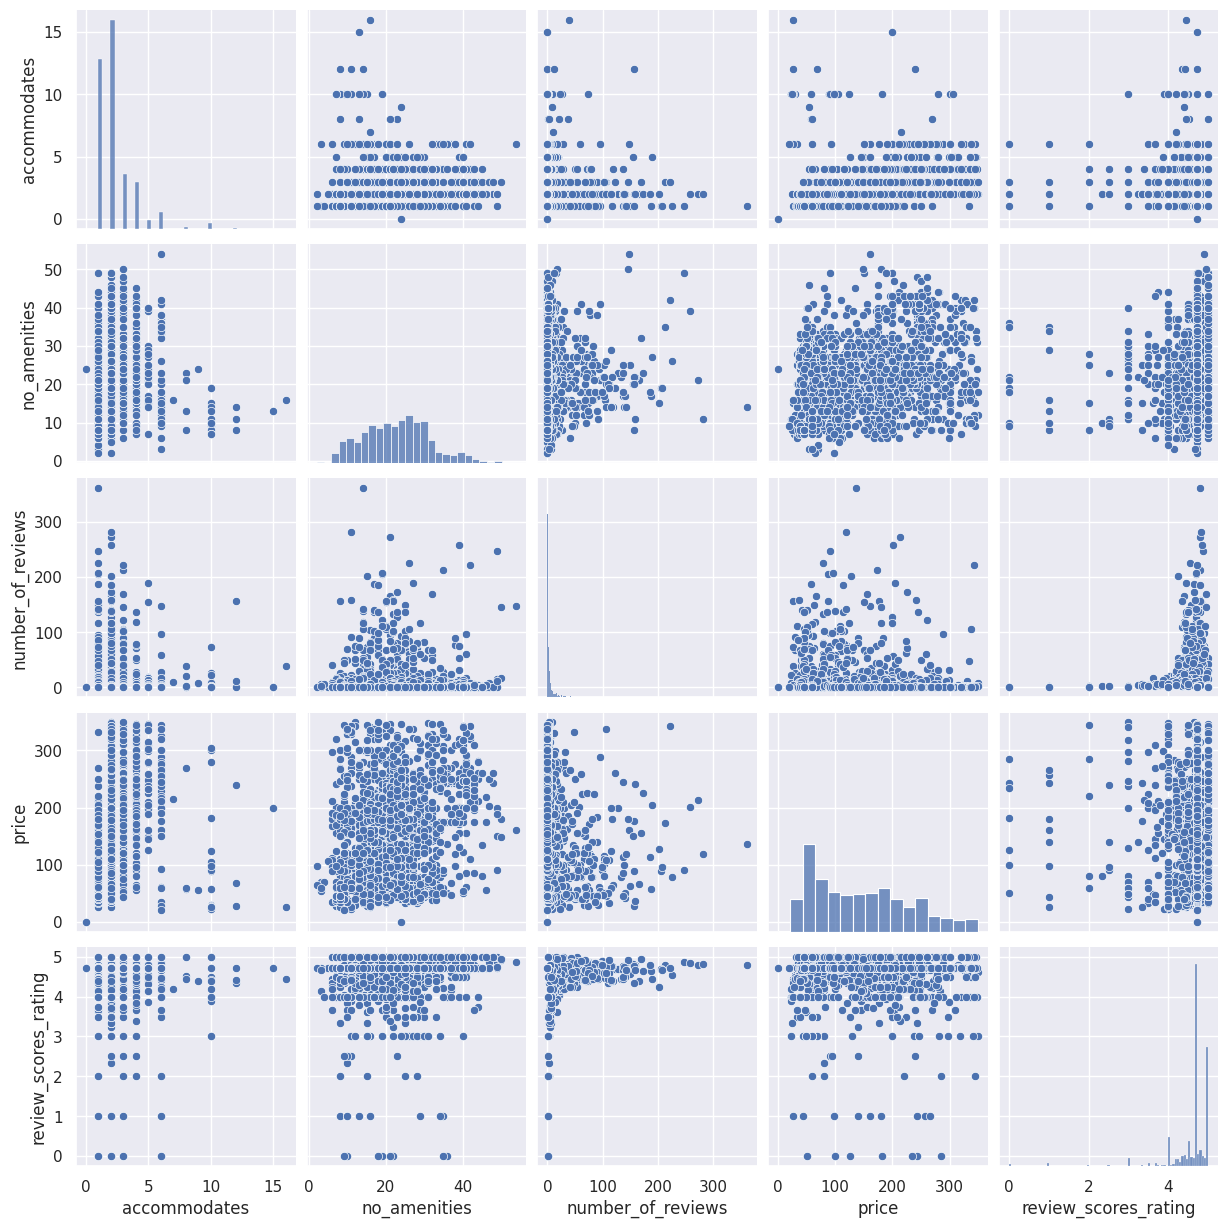

In [424]:
#Input the numerical values we had identified beforehand
kmeansDF = airDF[["accommodates","no_amenities","number_of_reviews", "price","review_scores_rating"]].copy()
# filling in null values with median
kmeansDF.fillna(kmeansDF.median(), inplace = True)

#Plot its data on 2d grids
sb.pairplot(kmeansDF)

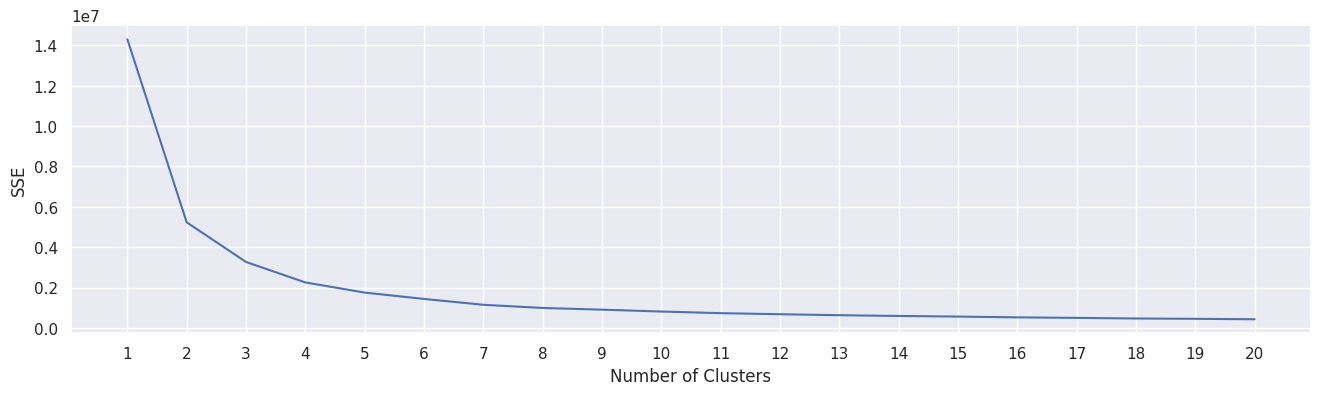

In [425]:
# Import kmeans model from sklearn
from sklearn.cluster import KMeans

#Vary the number of clusters
minClusterRange = 1
maxClusterRange = 20

#We want to use the elbow method, so we will compute all sse for each "k" and store into our sse list 
#"k-means++" employs an advanced trick to speed up convergence
sse = [] 
for k in range(minClusterRange, maxClusterRange + 1):
  kmeans = KMeans(n_clusters = k, init = "k-means++", n_init= 10)
  kmeans.fit(kmeansDF)
  sse.append(kmeans.inertia_)

#Plot the SSE curve to find our elbow point
f = plt.figure(figsize=(16,4))
plt.plot(range(minClusterRange, maxClusterRange+1), sse)
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.xticks(np.arange(minClusterRange, maxClusterRange+1, step = 1))
plt.show()
None

It seems from this that our elbow point is either 2 or 3 as our best k. Let us use another technique called silhouette coefficient to find out the best k

In [426]:
from sklearn.metrics.cluster import silhouette_score
silhouette_coefficients = []
minClusterRange = 2 #Start at 2 for silhouette coefficient
maxClusterRange = 20

for k in range(minClusterRange, maxClusterRange +1):
  kmeans = KMeans(n_clusters = k, init= "k-means++", n_init = 10)
  kmeans.fit(kmeansDF)
  score = silhouette_score(kmeansDF, kmeans.labels_)
  silhouette_coefficients.append(score)

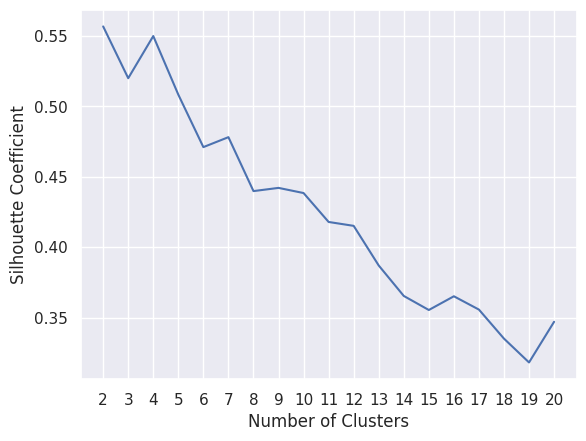

In [427]:
#Plot out what we have found based on our silhouette coefficients
plt.plot(range(minClusterRange, maxClusterRange + 1), silhouette_coefficients)
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.xticks(np.arange(minClusterRange, maxClusterRange+1, step = 1))
plt.show()

From this, let us try 2 as it has the highest score for now

In [428]:
k = 4

#Use our kmeans with our newly found k
kmeans = KMeans(n_clusters = k,         
               init = "k-means++",
               n_init = 10)                 

#Fit the kmeans onto our DF
kmeans.fit(kmeansDF)
#Then call predict 
kmeansPrediction = kmeans.predict(kmeansDF)
None

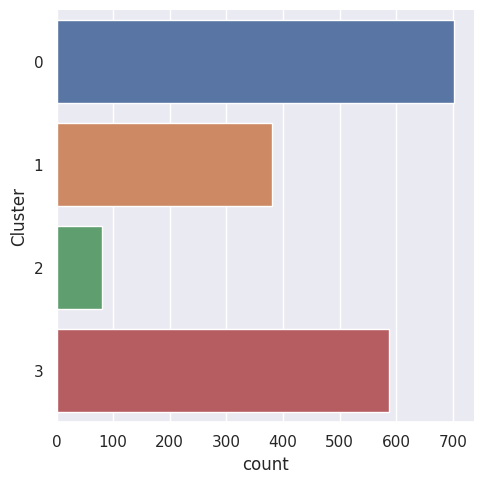

In [429]:
kmeans_labeled = kmeansDF.copy()
kmeans_labeled["Cluster"] = pd.Categorical(kmeansPrediction)

# Catplot the counts in our cluters
sb.catplot(y = "Cluster", data = kmeans_labeled, kind = "count")

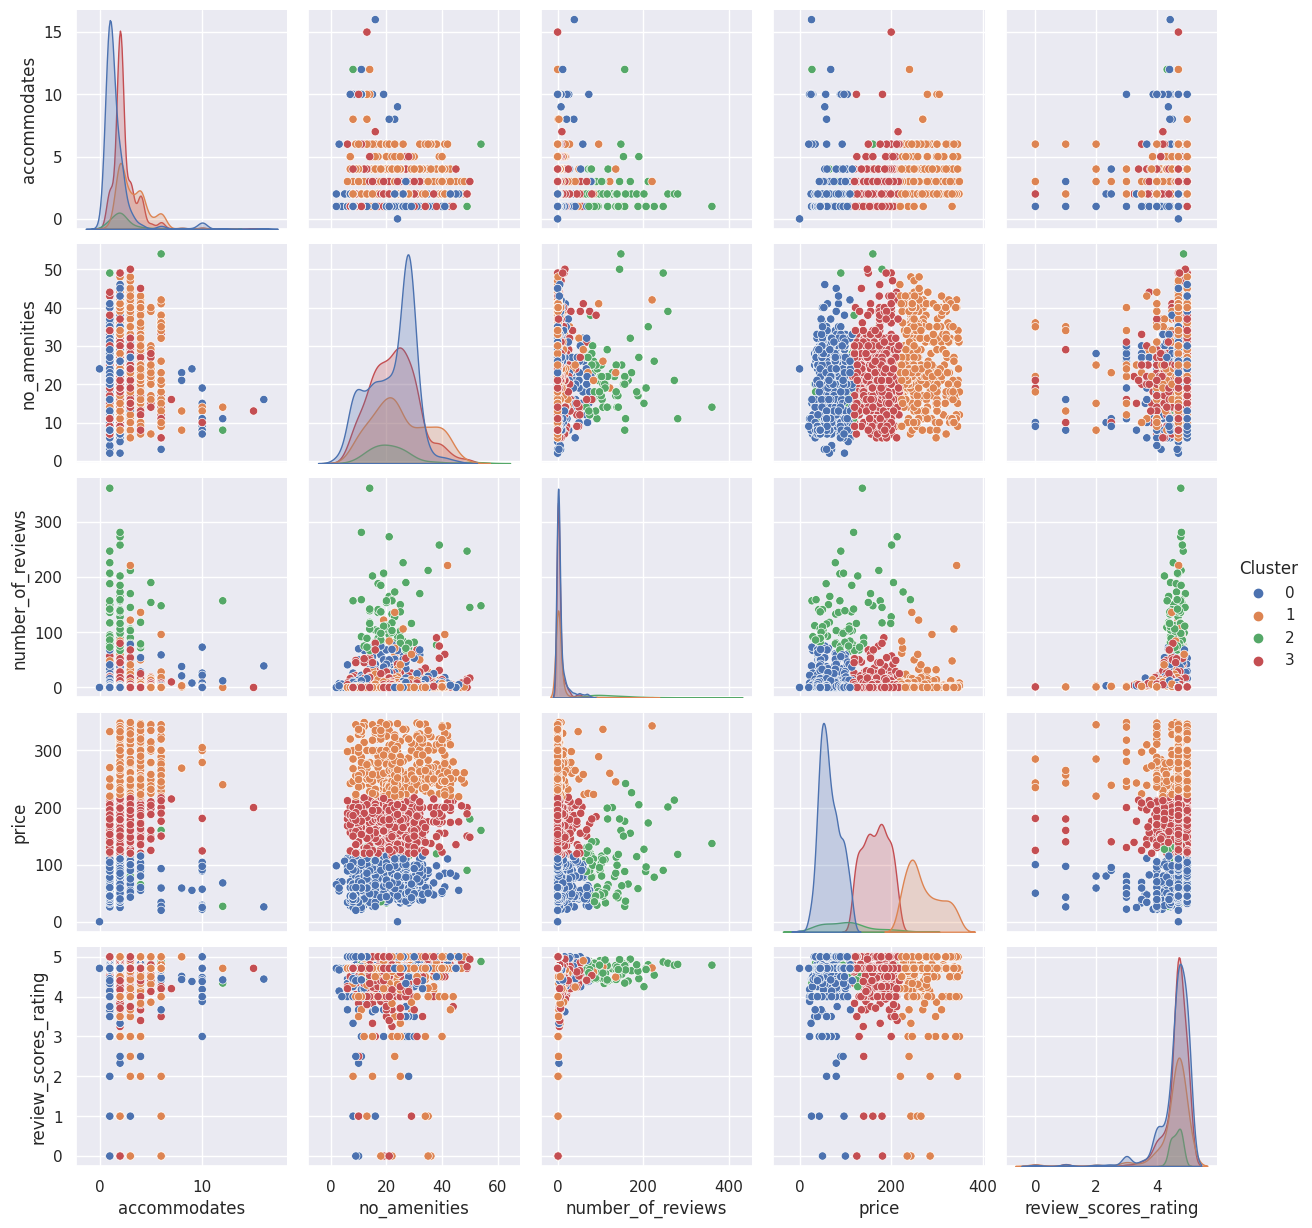

In [430]:
#Plot all our clusters on 2d grids using cluster column
sb.pairplot(kmeans_labeled, vars = kmeansDF.columns.values, hue = "Cluster")

<Axes: xlabel='review_scores_rating', ylabel='Cluster'>

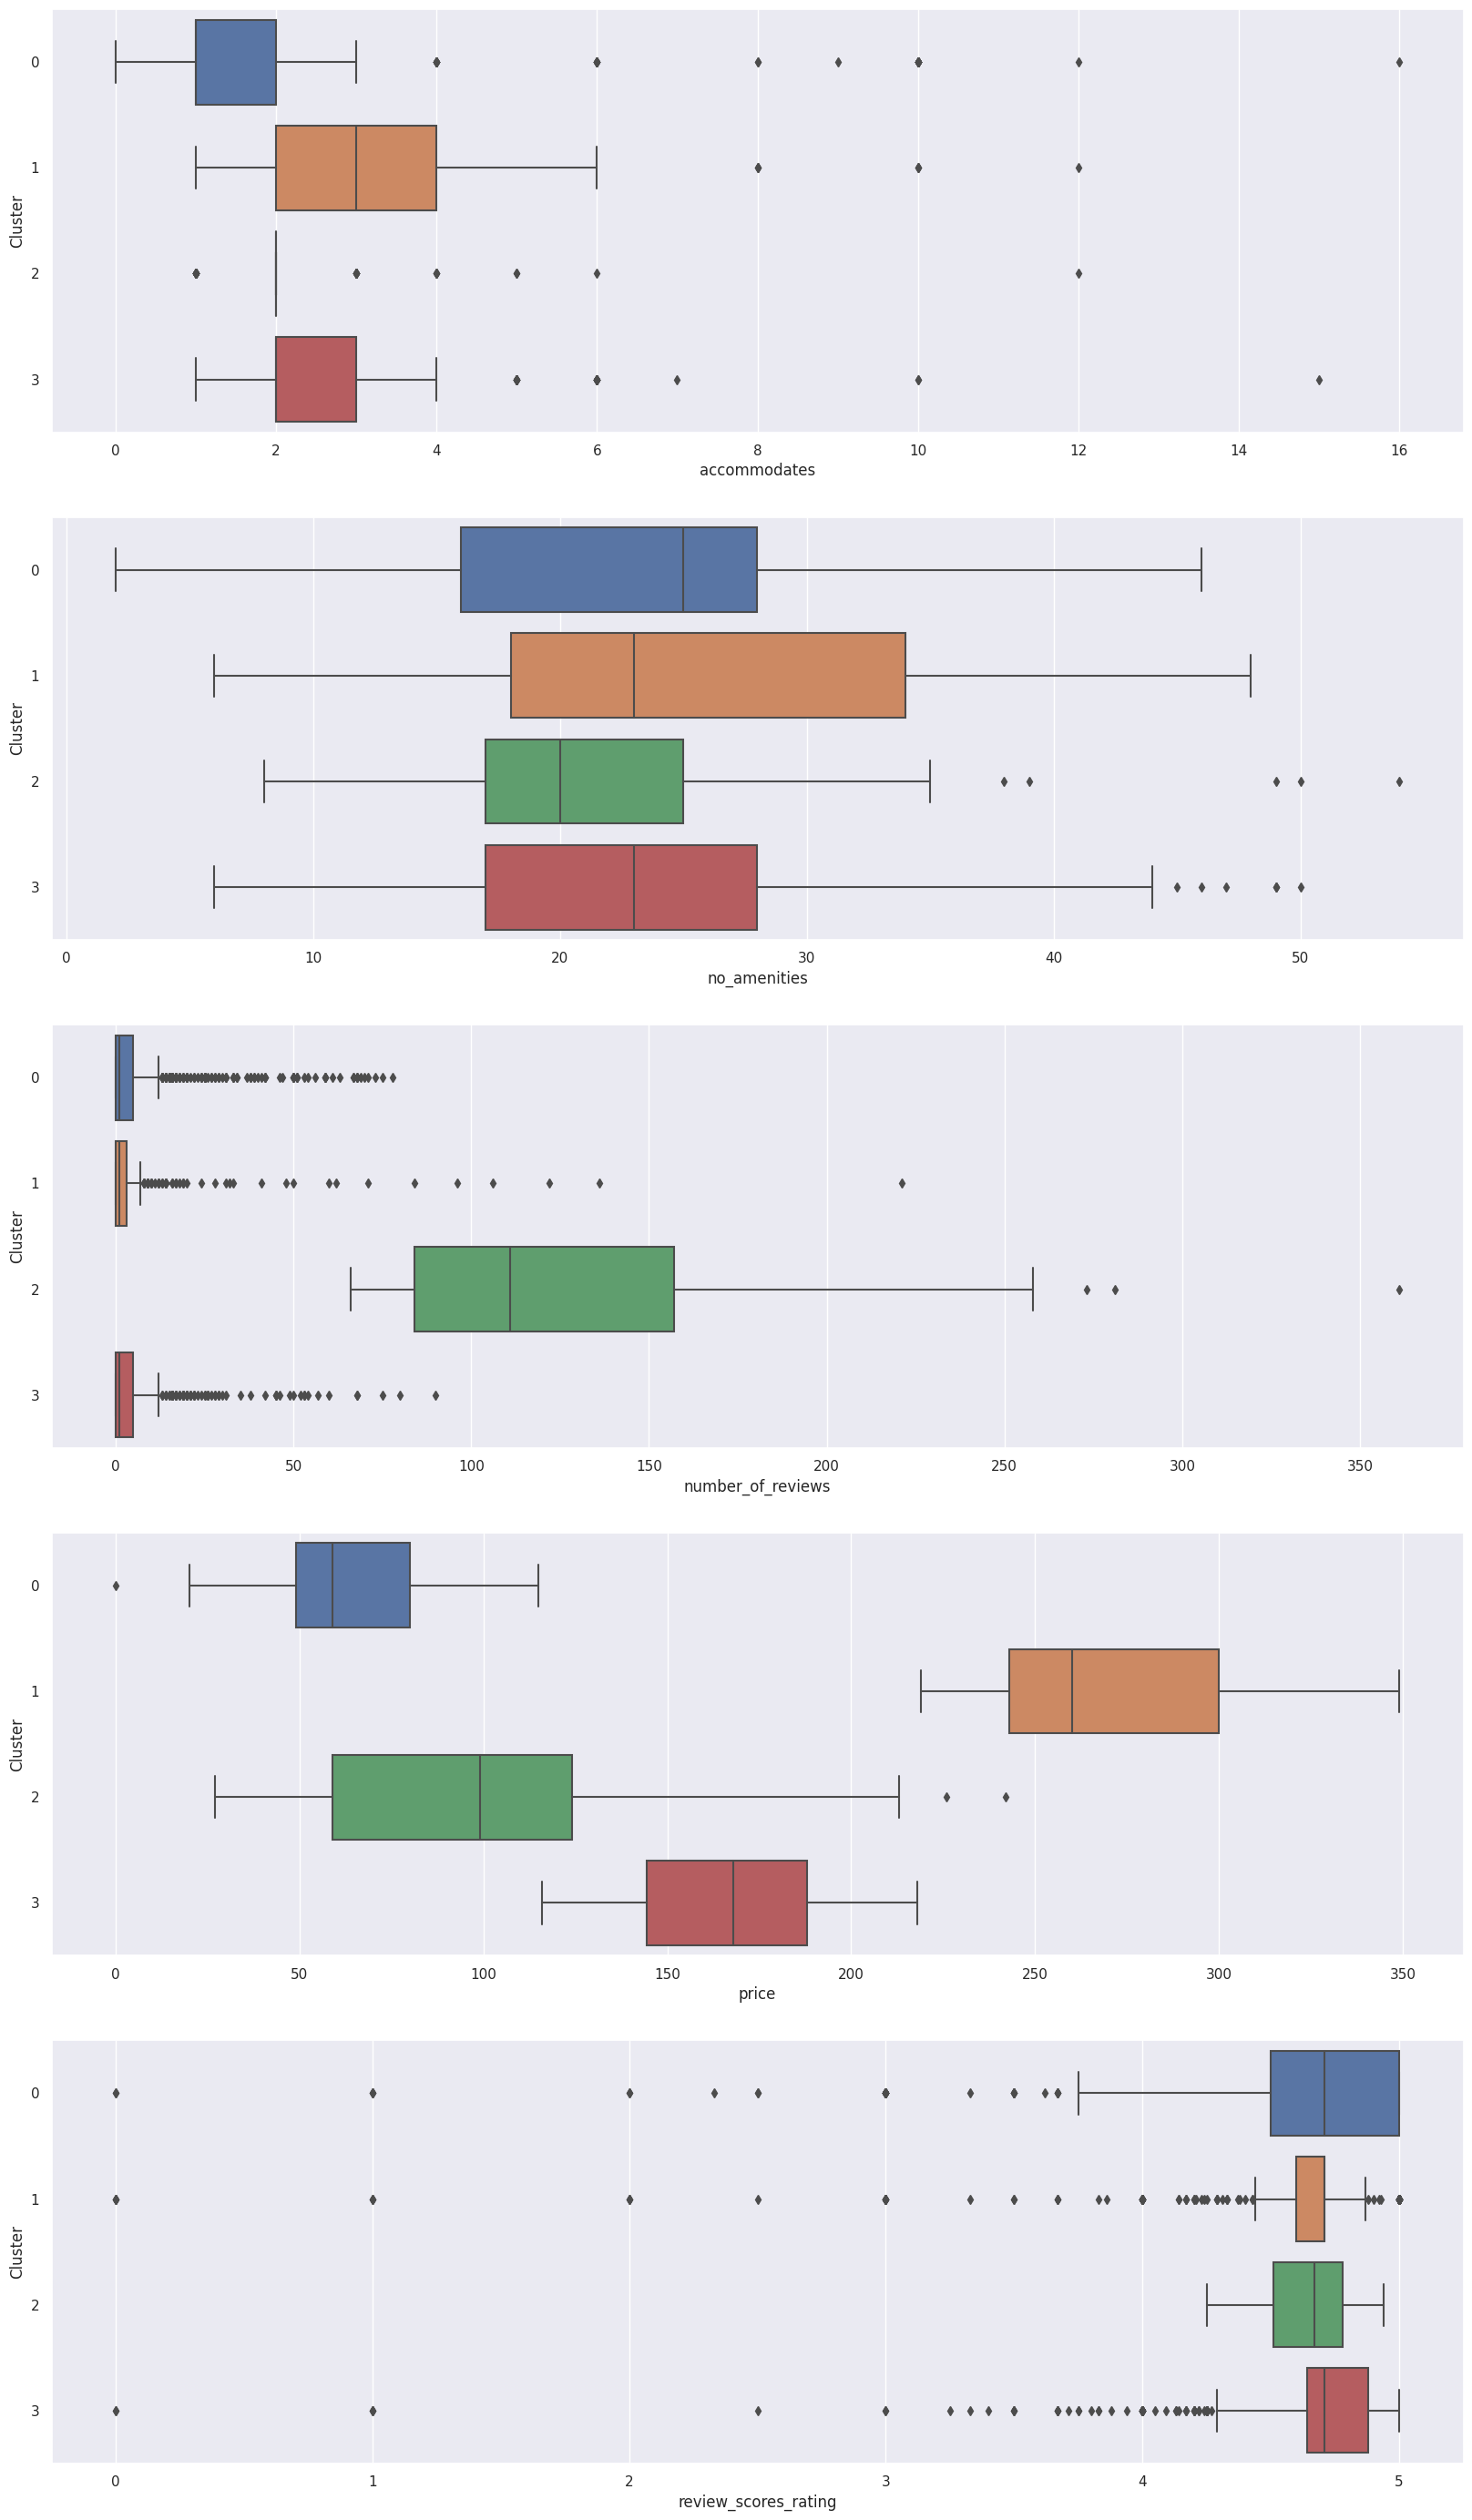

In [431]:
# Boxplots for all Features against the Clusters
f, axes = plt.subplots(5, 1, figsize=(20,35))
sb.boxplot(x = 'accommodates', y = 'Cluster', data = kmeans_labeled, ax = axes[0])
sb.boxplot(x = 'no_amenities', y = 'Cluster', data = kmeans_labeled, ax = axes[1])
sb.boxplot(x = 'number_of_reviews', y = 'Cluster', data = kmeans_labeled, ax = axes[2])
sb.boxplot(x = 'price', y = 'Cluster', data = kmeans_labeled, ax = axes[3])
sb.boxplot(x = 'review_scores_rating', y = 'Cluster', data = kmeans_labeled, ax = axes[4])

<Axes: xlabel='Cluster'>

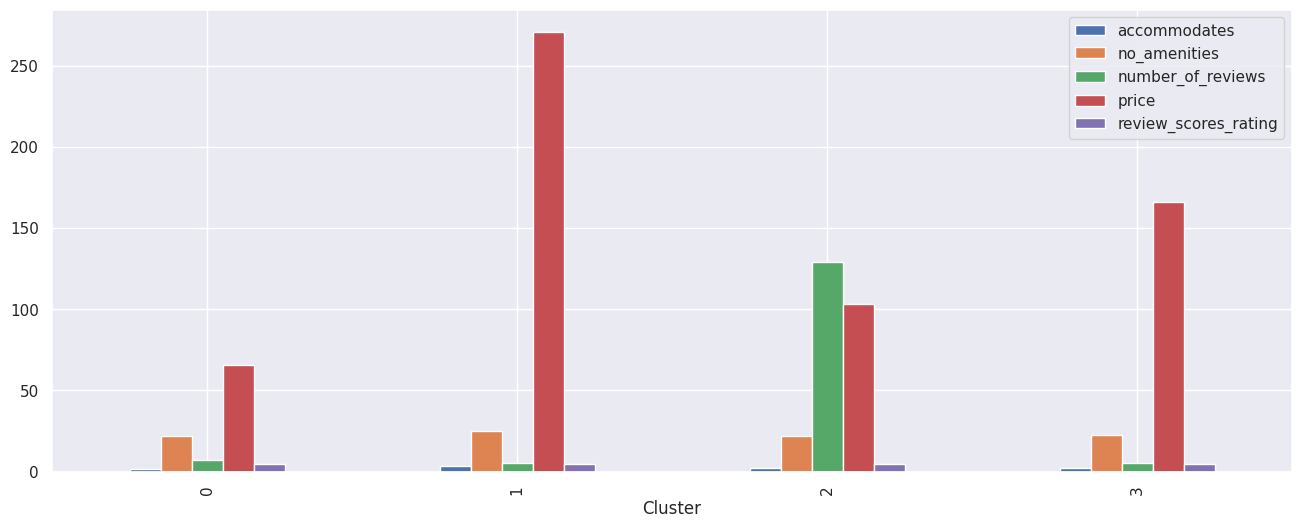

In [432]:
# Average Behaviour of each Cluster
cluster_data = pd.DataFrame(kmeans_labeled.groupby(by = "Cluster").mean())
cluster_data.plot.bar(figsize = (16,6))
     

<Axes: >

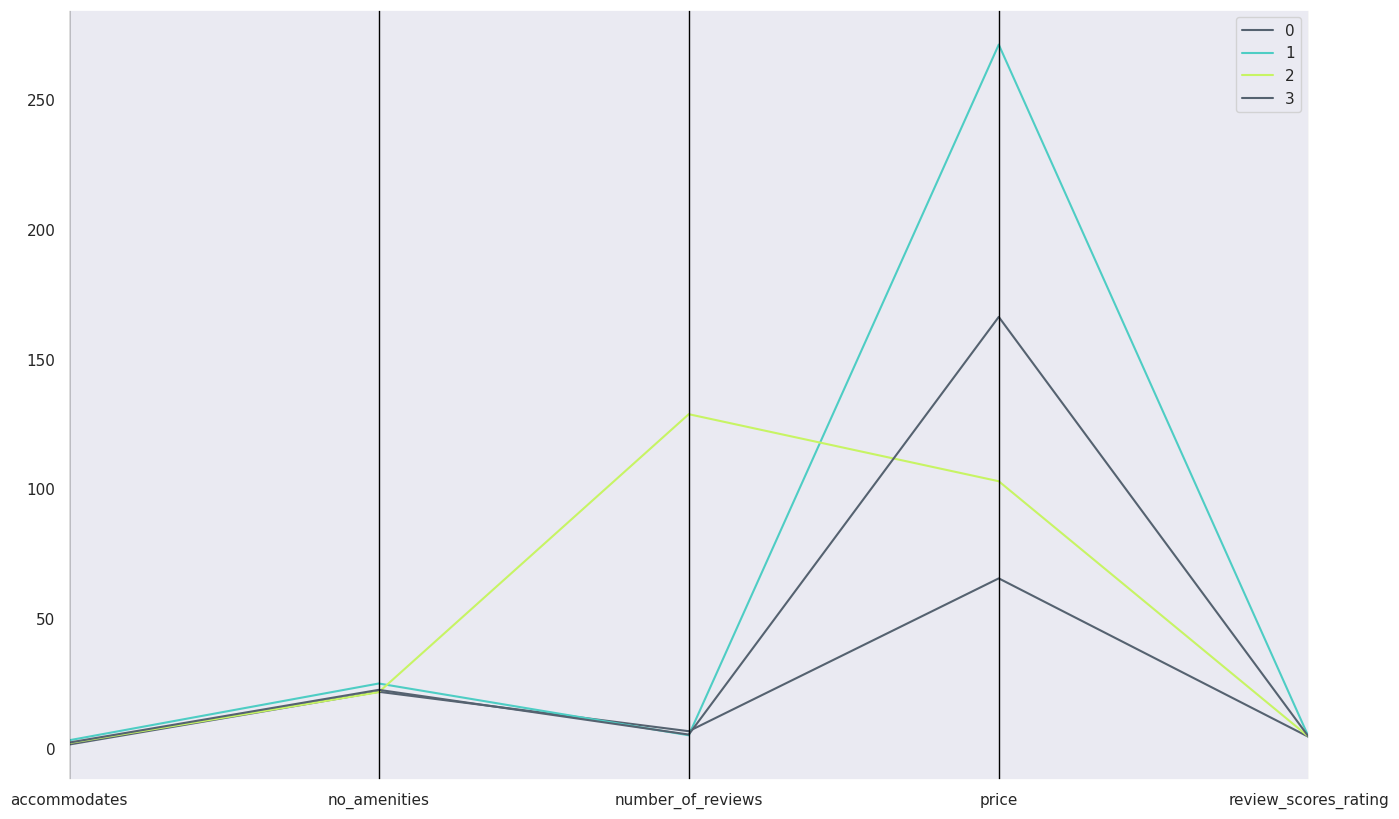

In [433]:
# Create a data frame containing our centroids
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=kmeansDF.columns)
centroids['Cluster'] = centroids.index

f, axes = plt.subplots(1, 1, figsize=(16,10))
pd.plotting.parallel_coordinates(centroids, 'Cluster', color=('#556270', '#4ECDC4', '#C7F464'))